In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

Selecting previously unselected package fonts-nanum.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


In [3]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 51.5 MB/s 


In [4]:
import pandas as pd
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

In [5]:
train = pd.read_csv("/content/drive/MyDrive/KSF/train_data.csv")
test = pd.read_csv("/content/drive/MyDrive/KSF/test_data.csv")
submission = pd.read_csv("/content/drive/MyDrive/KSF/sample_submission.csv")

In [6]:
print(train.shape)
print(test.shape)
print(submission.shape)

(24998, 4)
(1666, 4)
(1666, 2)


In [7]:
%load_ext google.colab.data_table

In [8]:
train

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral
...,...,...,...,...
24993,24993,"오페라에 비하여 오라토리오에서는 독창보다도 합창이 중시되며, 테스토 또는 이스토리쿠...",오라토리오에서 테스토의 역할이 가장 중요하다.,neutral
24994,24994,지하철역까지 걸어서 5분 정도 걸립니다.,지하철역까지 도보로 5분 정도 걸립니다.,entailment
24995,24995,한편 이날 중앙방역대책본부는 집단 감염이 발생한 음식점 관련 역학조사 결과를 공개했다.,중악방역대책본부는 집단 감염과 관련한 모든 정보를 비공개했다.,contradiction
24996,24996,마미손이 랩을 하자 시청자들은 그의 정체를 파악했다.,시청자들은 마미손의 정체를 안다.,entailment


In [9]:
test

,index,premise,hypothesis,label
0,0,다만 조금 좁아서 케리어를 펼치기 불편합니다.,케리어를 펼치기에 공간이 충분했습니다.,answer
1,1,그리고 위치가 시먼역보다는 샤오난먼역에 가까워요,시먼역보다는 샤오난먼역에 먼저 도착할 수 있어요,answer
2,2,구구절절 설명하고 이해시키려는 노력이 큰 의미없이 다가온다.,무엇인가 말을 많이 하기는 했지만 큰 의미가 있지는 않았다.,answer
3,3,몇 번을 다시봐도 볼 때마다 가슴이 저민다.,다시 봤을때는 무덤덤했다.,answer
4,4,"8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.",8월 중에 입주신청을 하면 신혼부부는 9월 부터 입주가 가능하다.,answer
...,...,...,...,...
1661,1661,"또 작업자의 숙련도와 경험 향상, 전문성을 요구하는 난이도 높은 데이터 가공을 통해...",이미지 데이터를 가공하는 것이 가장 난이도가 높다.,answer
1662,1662,결말을 보니 아무래도 이 영화는 2부가 계획된 듯 합니다.,결말을 보니 분명히 2편이 나올것이 틀림없다.,answer
1663,1663,사회적 거리 두기 상황에서 총리도 카페를 갔다가 자리가 없어서 퇴짜 맞은 일도 있을...,사회적 거리두기 상황에서는 고위관직자도 방역지침을 준수해야 한다.,answer
1664,1664,로마에서 3박4일간 이곳에서 머물렀습니다.,이곳에서 머무르며 로마의 명소들을 방문했습니다.,answer


In [10]:
submission

,index,label
0,0,answer
1,1,answer
2,2,answer
3,3,answer
4,4,answer
...,...,...
1661,1661,answer
1662,1662,answer
1663,1663,answer
1664,1664,answer


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


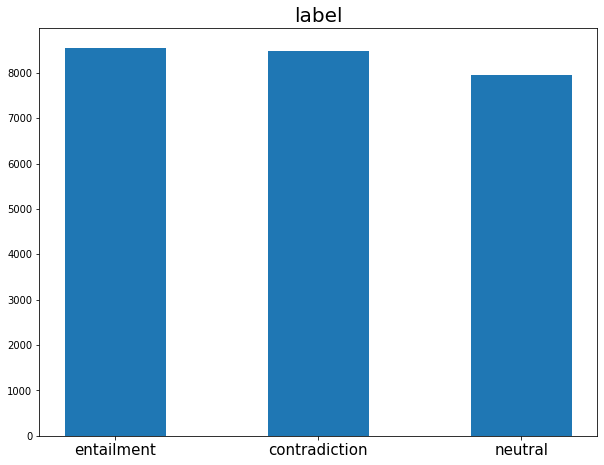

In [11]:
feature = train['label']

plt.figure(figsize=(10,7.5)) # 그래프 이미지 크기 설정

plt.title('label', fontsize=20)
temp = feature.value_counts() # feature 변수의 변수별 개수 계산
plt.bar(temp.keys(), temp.values, width=0.5)
plt.xticks(temp.keys(), fontsize=15) 
plt.show()


In [12]:
premise_len_mean = np.mean(train['premise'].str.len()) # 리뷰 길이의 평균값 계산
print('실제 Text 평균 길이 :',premise_len_mean)

hypo_len_mean = np.mean(train['hypothesis'].str.len()) # 리뷰 길이의 평균값 계산
print('가설 Text 평균 길이 :',hypo_len_mean)

실제 Text 평균 길이 : 45.406552524201935
가설 Text 평균 길이 : 24.924433954716378


In [13]:
# 데이터 필터링을 위한 마스크 설정 (premise 부분만)
mask_true = (train.label == 'entailment')
mask_false = (train.label == 'contradiction')
mask_neutral = (train.label == 'neutral')

df_train = train.premise.copy()

df_true = train.loc[mask_true,:].premise 
df_false = train.loc[mask_false,:].premise 
df_neu = train.loc[mask_neutral,:].premise 

# 세 집합을 리스트로 묶어줍니다.
compare = [df_train, df_true, df_false, df_neu]

In [14]:
df_true.head()

2                       이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.
5     이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나...
10                       대부분 도보로 이동하기 충분하다는 점이 매력적이었어요.
12                          영화 시작부터 끝까지 긴장감을 늦출 수가 없네요.
16    국토교통부는 연료보조금 지급 근거를 마련하기 위해 올해 하반기에 여객자동차 및 화물...
Name: premise, dtype: object

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


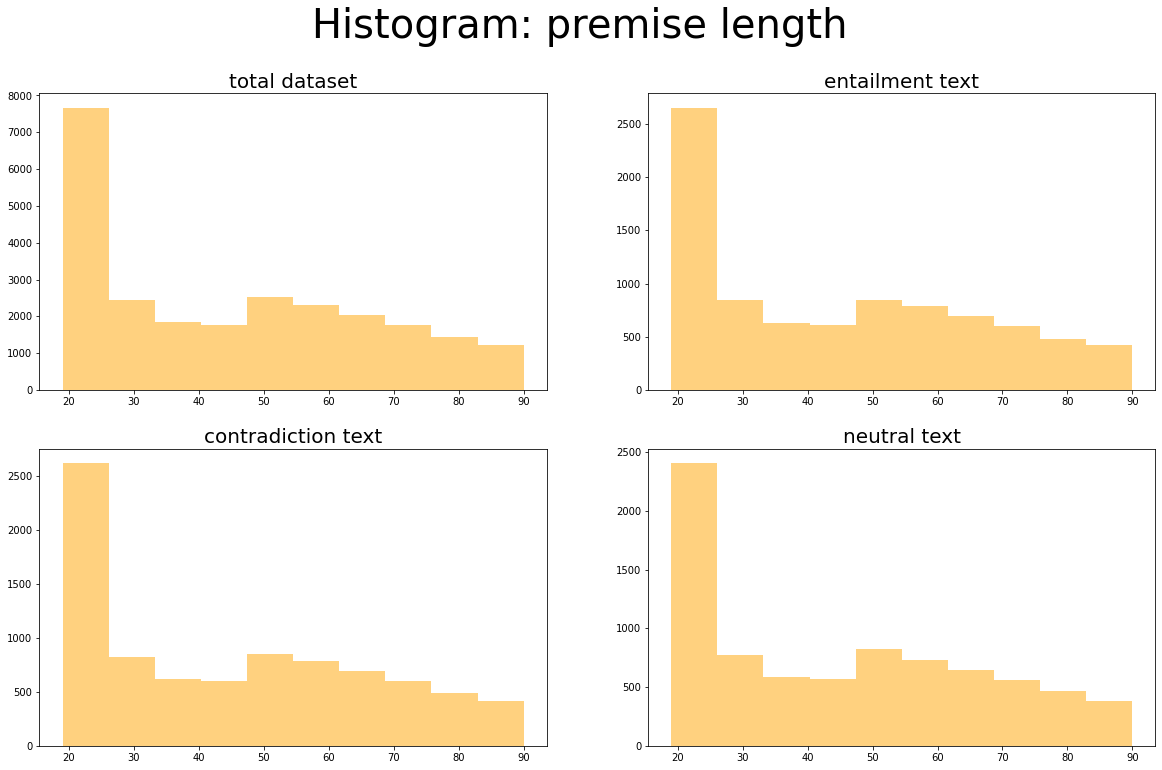

In [15]:
# 히스토그램 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: premise length", fontsize=40)
name = ['total dataset', 'entailment text', 'contradiction text', 'neutral text']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document]
     
    plt.subplot(2, 2, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='orange') 
    
plt.show()

In [16]:
# 데이터 필터링을 위한 마스크 설정 (Hypothesis  부분만)
mask_true = (train.label == 'entailment')
mask_false = (train.label == 'contradiction')
mask_neutral = (train.label == 'neutral')

df_train = train.hypothesis .copy()

df_true = train.loc[mask_true,:].hypothesis 
df_false = train.loc[mask_false,:].hypothesis 
df_neu = train.loc[mask_neutral,:].hypothesis 

# 세 집합을 리스트로 묶어줍니다.
compare = [df_train, df_true, df_false, df_neu]

In [17]:
df_true.head()

2     예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.
5         코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.
10                            대부분 걸어서 갈수 있어요.
12                        영화 시작부터 긴장감이 함께하네요.
16      여객자동차 및 화물자동차 운수사업법을 국토교통부가 개정할 계획이다.
Name: hypothesis, dtype: object

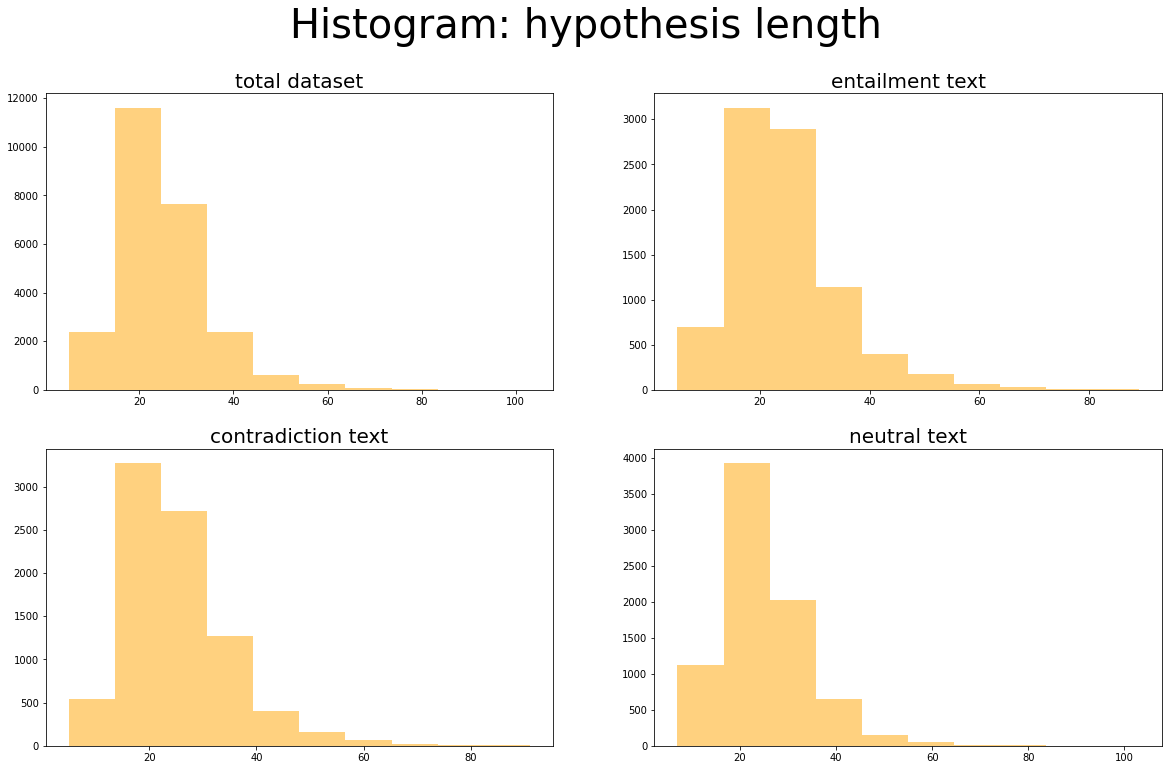

In [18]:
# 히스토그램을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,12))
plt.suptitle("Histogram: hypothesis length", fontsize=40)
name = ['total dataset', 'entailment text', 'contradiction text', 'neutral text']

for i in range(len(compare)):
    document = compare[i]
    string_len = [len(x) for x in document] 
    plt.subplot(2, 2, i+1)
    plt.title(name[i], fontsize=20)
    plt.hist(string_len, alpha=0.5, color='orange') 
    
plt.show()

In [19]:
def df2str(df):
    #전체 리뷰들을 하나의 문자열로 만듦
    s = [s for s in df]
    document = ""
    for i in range(len(s)):
        document += s[i]
    return document

def get_noun(text):
    # okt tagger를 이용해 명사 추출
    okt = Okt()
    noun = okt.nouns(text)
    for i,v in enumerate(noun):
        if len(v)<2:
            noun.pop(i)
    count = Counter(noun)
    noun_list = count.most_common(100)

    return noun_list

def visualize(noun_list, title):
    # 워드클라우드 이미지 생성
    wc= WordCloud(
        background_color='white',                             # 배경 색깔 정하기
        colormap = 'Dark2',                                # 폰트 색깔 정하기
        font_path = font_path,
        width = 800,
        height = 800).generate_from_frequencies(dict(noun_list)) 
    
    plt.figure(figsize=(10,10)) #이미지 사이즈 지정
    plt.title(title, fontsize=20)
    plt.imshow(wc, interpolation='lanczos') #이미지의 부드럽기 정도
    plt.axis('off') #x y 축 숫자 제거
    plt.show()  # 워드클라우드 이미지 확인
    
    return wc

In [20]:
document = df2str(df_train) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10] 

[('영화', 2053),
 ('숙소', 713),
 ('사람', 539),
 ('호스트', 443),
 ('위치', 421),
 ('사업', 401),
 ('대한', 342),
 ('가장', 336),
 ('지원', 328),
 ('예정', 316)]

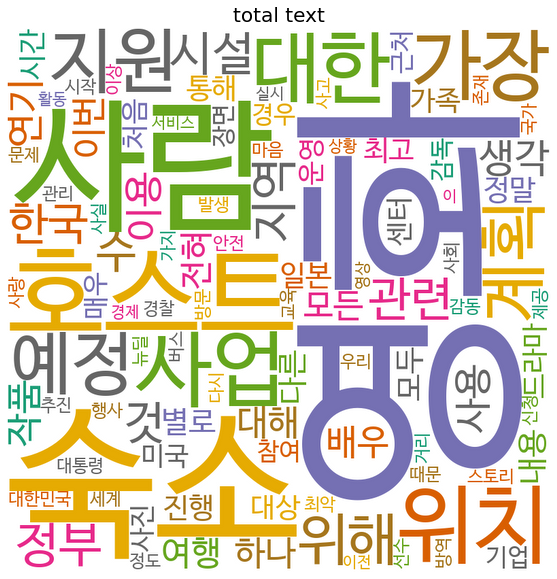

In [21]:
total_text = visualize(noun_list,'total text')

## Entailment

In [22]:
document = df2str(df_true) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10] 

[('영화', 700),
 ('숙소', 244),
 ('사람', 182),
 ('위치', 169),
 ('사업', 149),
 ('호스트', 146),
 ('위해', 122),
 ('지원', 122),
 ('시설', 111),
 ('수', 108)]

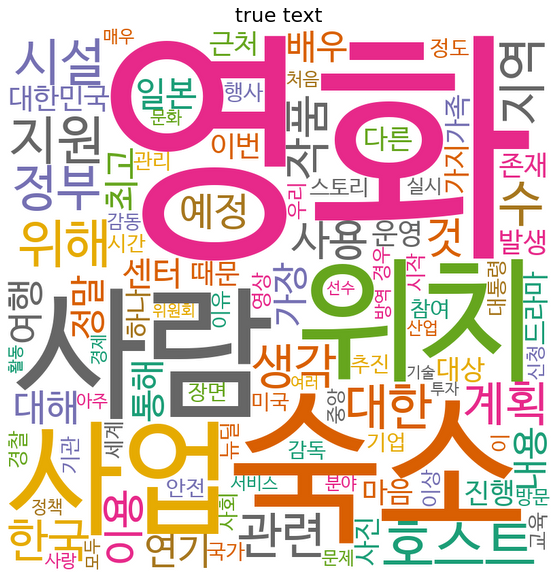

In [23]:
true_text = visualize(noun_list,'true text')

## Contradiction

In [24]:
document = df2str(df_false) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10]

[('영화', 700),
 ('숙소', 238),
 ('전혀', 198),
 ('사람', 181),
 ('별로', 165),
 ('위치', 146),
 ('호스트', 144),
 ('사업', 142),
 ('관련', 130),
 ('대한', 126)]

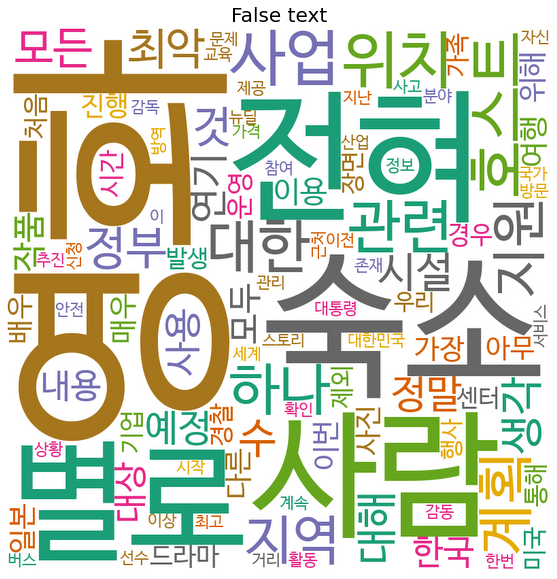

In [25]:
false_text = visualize(noun_list,'False text')

## Neutral

In [26]:
document = df2str(df_neu) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10] 

[('영화', 653),
 ('숙소', 231),
 ('가장', 192),
 ('사람', 176),
 ('호스트', 153),
 ('예정', 140),
 ('위해', 113),
 ('대한', 110),
 ('사업', 110),
 ('위치', 106)]

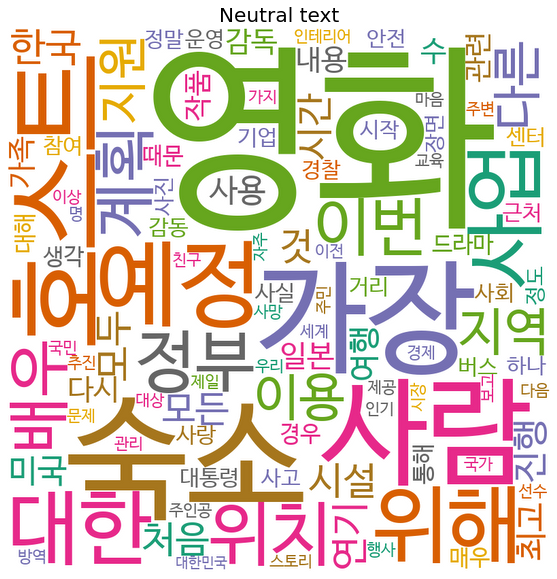

In [27]:
neutral_text = visualize(noun_list,'Neutral text')

In [28]:
df_hy_train = train.hypothesis.copy()

df_hy_true = train.loc[mask_true,:].hypothesis 
df_hy_false = train.loc[mask_false,:].hypothesis 
df_hy_neu = train.loc[mask_neutral,:].hypothesis 

## Entailment

In [29]:
document = df2str(df_hy_true) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10] 

[('영화', 700),
 ('숙소', 244),
 ('사람', 182),
 ('위치', 169),
 ('사업', 149),
 ('호스트', 146),
 ('위해', 122),
 ('지원', 122),
 ('시설', 111),
 ('수', 108)]

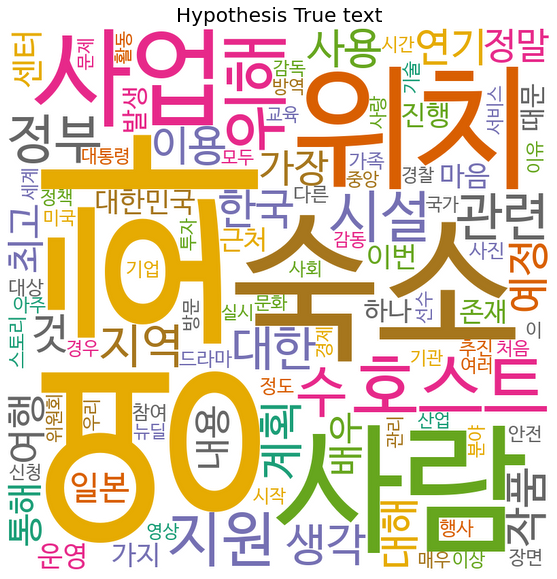

In [30]:
true_text = visualize(noun_list,'Hypothesis True text')

## Contradiction

In [31]:
document = df2str(df_hy_false) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10] 

[('영화', 700),
 ('숙소', 238),
 ('전혀', 198),
 ('사람', 181),
 ('별로', 165),
 ('위치', 146),
 ('호스트', 144),
 ('사업', 142),
 ('관련', 130),
 ('대한', 126)]

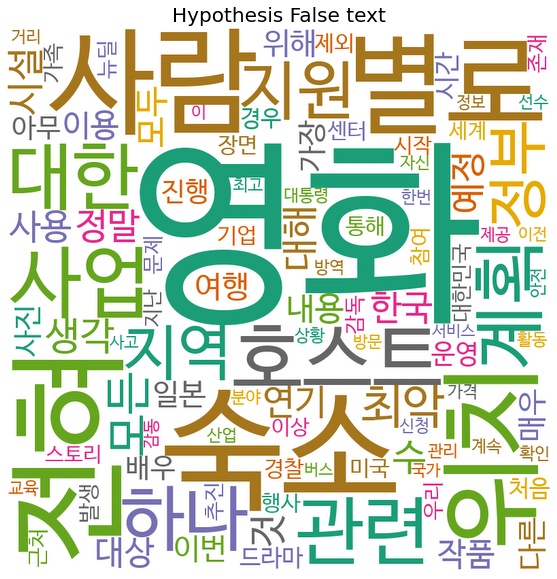

In [32]:
false_text = visualize(noun_list,'Hypothesis False text')

## Neutral

In [33]:
document = df2str(df_hy_neu) # 전체 리뷰들을 하나의 문자열로 만듦
noun_list = get_noun(document) # 명사 추출, 개수 셈
noun_list[:10] 

[('영화', 653),
 ('숙소', 231),
 ('가장', 192),
 ('사람', 176),
 ('호스트', 153),
 ('예정', 140),
 ('위해', 113),
 ('대한', 110),
 ('사업', 110),
 ('위치', 106)]

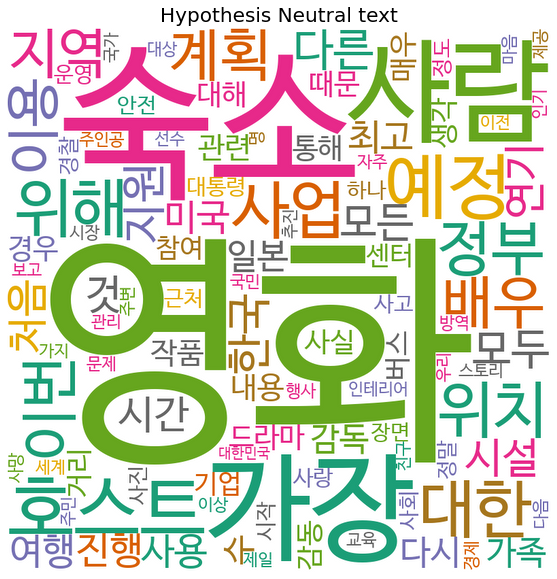

In [34]:
neutral_text = visualize(noun_list,'Hypothesis Neutral text')

In [35]:
pip install pororo

     |████████████████████████████████| 256 kB 5.1 MB/s 
     |████████████████████████████████| 1.5 MB 46.6 MB/s 
     |████████████████████████████████| 1.2 MB 36.3 MB/s 
     |████████████████████████████████| 42.4 MB 1.5 MB/s 
     |████████████████████████████████| 3.1 MB 34.7 MB/s 
     |████████████████████████████████| 5.9 MB 20.6 MB/s 
     |████████████████████████████████| 3.5 MB 33.5 MB/s 
     |████████████████████████████████| 748.8 MB 19 kB/s 
     |████████████████████████████████| 468 kB 48.3 MB/s 
     |████████████████████████████████| 79 kB 8.0 MB/s 
     |████████████████████████████████| 1.7 MB 35.8 MB/s 
     |████████████████████████████████| 90 kB 9.5 MB/s 
     |████████████████████████████████| 145 kB 43.5 MB/s 
     |████████████████████████████████| 748 kB 48.4 MB/s 
     |████████████████████████████████| 1.2 MB 43.6 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 48.8 MB/s 
     |███████████████

In [37]:
from pororo import Pororo

Pororo.available_tasks()

"Available tasks are ['mrc', 'rc', 'qa', 'question_answering', 'machine_reading_comprehension', 'reading_comprehension', 'sentiment', 'sentiment_analysis', 'nli', 'natural_language_inference', 'inference', 'fill', 'fill_in_blank', 'fib', 'para', 'pi', 'cse', 'contextual_subword_embedding', 'similarity', 'sts', 'semantic_textual_similarity', 'sentence_similarity', 'sentvec', 'sentence_embedding', 'sentence_vector', 'se', 'inflection', 'morphological_inflection', 'g2p', 'grapheme_to_phoneme', 'grapheme_to_phoneme_conversion', 'w2v', 'wordvec', 'word2vec', 'word_vector', 'word_embedding', 'tokenize', 'tokenise', 'tokenization', 'tokenisation', 'tok', 'segmentation', 'seg', 'mt', 'machine_translation', 'translation', 'pos', 'tag', 'pos_tagging', 'tagging', 'const', 'constituency', 'constituency_parsing', 'cp', 'pg', 'collocation', 'collocate', 'col', 'word_translation', 'wt', 'summarization', 'summarisation', 'text_summarization', 'text_summarisation', 'summary', 'gec', 'review', 'review_s

In [41]:
from pororo.pororo import SUPPORTED_TASKS
SUPPORTED_TASKS['nli'].get_available_langs()

['en', 'ko', 'ja', 'zh']

In [45]:
nli = Pororo(task='nli', lang='ko')

In [46]:
nli('이번 증설로 코오롱인더스트리는 기존 생산량 7만7000톤에서 1만6800톤이 늘어나 총 9만 3800톤의 생산 능력을 확보하게 됐다.', '코오롱 인더스트리는 총 9만 3800톤의 생산 능력을 확보했다.')

'Entailment'

In [47]:
nli('광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 적극 나섰다.', '원주민들은 종합대책에 만족했다.')

'Neutral'

In [48]:
nli('광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 적극 나섰다.', '아기자기한 실내소품들은 사진에서 본 것과 차이가 있었습니다.')

'Neutral'

In [50]:
nli('빠른 답장과 간편한 체크인, 깨끗한 집 좋았어요', '체크인이 복잡했어요.')

'Contradiction'

In [51]:
nli('2003년 변정수 씨가 교통사고로 죽었다는 이야기가 돌았지만 사실무근이었다.', '2003년 변정수 씨는 교통사고를 당했다.')

'Entailment'

In [52]:
nli('마지막에 존트라볼타 지하철에서 혼자 담배 무는 장면 압권이네요.', '존트라볼타 지하철에서는 원칙상 담배를 피면 안된다.')

'Contradiction'

## 제로샷 토픽 분류(Zero-shot topic classification)

In [53]:
ZSl = Pororo(task="zero-topic", lang='ko')

In [55]:
ZSl('시대상황을 고려하는 현명한 시청태도가 요구되다.', ['정치', '사회', '스포츠', '연예', '국제'])

{'국제': 4.26, '사회': 92.29, '스포츠': 3.08, '연예': 23.46, '정치': 6.66}

In [57]:
ZSl('8월 중에 입주신청을 하면 청년은 9월, 신혼부부는 10월부터 입주가 가능하다.', ['정치', '사회', '스포츠', '연예', '국제'])

{'국제': 15.9, '사회': 36.06, '스포츠': 2.72, '연예': 25.37, '정치': 2.58}

In [62]:
ZSl('현행 여객자동차법상 택시 운전업무에 종사하려는 자는 택시운전 자격 취득과 법정필수교육을 이수해야 하며 이를 이행하기 전에는 택시 운행이 불가능하다.', ['교통', '법', '버스', '비행기', '자격증'])

{'교통': 92.55, '버스': 0.37, '법': 94.23, '비행기': 0.35, '자격증': 91.89}

In [56]:
ZSl('현재 장성택의 매형인 전영진 쿠바 주재 북한 대사와 조카인 장용철 말레이시아 대사도 조선민주주의인민공화국 본국으로 소환된 것으로 전해졌다.', ['정치', '사회', '스포츠', '연예', '국제'])

{'국제': 21.41, '사회': 23.33, '스포츠': 5.28, '연예': 23.45, '정치': 14.31}

In [60]:
ZSl('현재 장성택의 매형인 전영진 쿠바 주재 북한 대사와 조카인 장용철 말레이시아 대사도 조선민주주의인민공화국 본국으로 소환된 것으로 전해졌다.', ['정치', '사회', '스포츠', '북한', '연예', '국제', '외교'])

{'국제': 21.41,
 '북한': 71.79,
 '사회': 23.33,
 '스포츠': 5.28,
 '연예': 23.45,
 '외교': 47.06,
 '정치': 14.31}